**import library**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import tensorflow as tf
from tensorflow import keras
import numpy as np
from torch.utils.data import DataLoader, RandomSampler

**Read dataset**

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

**Data preprocessing**

In [10]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

**Defining model**

In [11]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

**Data partitioning**

In [12]:
def split_data(x_data, y_data, num_clients=5):
    client_data = []
    num_items_per_client = x_data.shape[0] // num_clients
    for i in range(num_clients):
        start = i * num_items_per_client
        end = start + num_items_per_client
        client_x = x_data[start:end]
        client_y = y_data[start:end]
        if client_x.size > 0 and client_y.size > 0:
            client_data.append((client_x, client_y))
    return client_data

**Implement FedAvg algorithm and evaluation**

In [13]:
def federated_averaging(clients, model_constructor, x_test, y_test, rounds=10):
    global_model = model_constructor()
    accuracy_history = []

    for _ in range(rounds):
        local_weights = []
        for client_x, client_y in clients:
            local_model = model_constructor()
            local_model.set_weights(global_model.get_weights())
            local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            local_model.fit(client_x, client_y, epochs=1, verbose=0)
            local_weights.append(local_model.get_weights())

        new_weights = [np.mean([x[i] for x in local_weights], axis=0) for i in range(len(local_weights[0]))]
        global_model.set_weights(new_weights)

        # 评估全局模型
        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        accuracy_history.append(accuracy)

    return global_model, accuracy_history


**Model training**

In [14]:
clients = split_data(x_train, y_train)
global_model, accuracy_history = federated_averaging(clients, create_model, x_test, y_test)

**Results visualization**

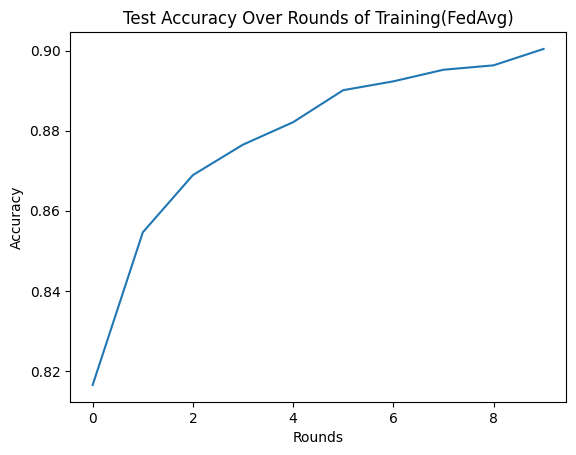

Final test accuracy: 0.9003999829292297


In [15]:
plt.plot(accuracy_history)
plt.title('Test Accuracy Over Rounds of Training(FedAvg)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()
print(f"Final test accuracy: {accuracy_history[-1]}")

In [16]:
print(f"Test accuracy: {accuracy_history}")

Test accuracy: [0.8165000081062317, 0.8546000123023987, 0.8689000010490417, 0.8765000104904175, 0.882099986076355, 0.8901000022888184, 0.892300009727478, 0.8952000141143799, 0.8963000178337097, 0.9003999829292297]
